In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(np.__version__)
print(pd.__version__)

1.21.0
1.1.4


In [3]:
os.chdir('../')

In [4]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_volume


In [5]:
# connect to the db
# config_file = "config/config_eagle.yaml"
config_file = "/projects/rlmolecule/jlaw/crystal_vol/opt_cvol_mcts100_debug/run.yaml"
run_config = RunConfig(config_file)
engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()

In [6]:
def load_games_played(session, run_id):
#     print("Loading games")
    df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

    df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('time_hours')
    df_games = df
    df_games.reset_index(drop=True, inplace=True)
#     print(df_games.tail(3))
    return df_games


def load_rewards(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
    # df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('reward', ascending=False)
    df_rew = df
#     print(df_rew.tail(3))
    return df_rew


def load_states(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(StateStore).filter_by(run_id=run_id).statement, session.bind)
    return df

def get_state_for_rew(digest, df_state):
    return df_state[df_state['digest'] == digest]


# def write_best_crystals():
#     df_rew = load_rewards

In [7]:
def plot_reward_train_curves(df, log, out_dir, title=""):
    fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(3, 2.75), dpi=150)
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)
    axs[1].legend(
        loc='upper right', ncol=2,
        borderpad=0, borderaxespad=0.1,
        bbox_to_anchor=(1.1, 1.2))

    # axs[0].set_ylim([0, 250])
#     axs[0].set_ylim([0, 1.0])
    #axs[1].set_ylim([0, .7])
    #axs[1].set_xlim([-.01, 4])
    axs[0].set_ylabel('Reward')
    axs[1].set_ylabel('Policy Training')
    axs[1].set_xlabel('Time (hours)')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.suptitle(title, y=1.0)

    out_file = f"{out_dir}/training-and-reward.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

# Compare Experiment Results

In [8]:
exp_name = "crystal_vol"
run_id = run_config.run_id
print(run_id)

opt_cvol_mcts100_debug


In [9]:
def main_results(run_id, session):
    working_dir = f"/projects/rlmolecule/jlaw/{exp_name}/{run_id}"
    # load the games played
    df_games = load_games_played(session, run_id)
    print(df_games.head())

    log_file = f"{working_dir}/policy_checkpoints/log.csv"
    print(f"Reading {log_file}")
    log = pd.read_csv(log_file)
    log['time'] = pd.to_datetime(log.time)
    log['time'] = pd.to_datetime(log.time)
    log['time_hours'] = (log.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
#     print(log.tail(3))

    # now plot the results
    out_dir = f"{working_dir}/viz"
    plot_reward_train_curves(df_games, log, out_dir, title=run_id)

    # and write POSCAR files for the best molecules
    df_rew = load_rewards(session, run_id)
    print(df_rew.head())
    return df_rew

                                     id                  run_id  \
0  979c1665-1239-4e14-9712-3d0ac889d515  opt_cvol_mcts100_debug   
1  9b9922cb-6096-4490-b959-85f40a54a315  opt_cvol_mcts100_debug   
2  1b60a1df-c1f0-4f9d-a055-7b2778a8b4d1  opt_cvol_mcts100_debug   
3  453927b9-467e-4cca-8c63-47565cd51b4c  opt_cvol_mcts100_debug   
4  51f42ee7-6287-4644-a16e-c1c242013cec  opt_cvol_mcts100_debug   

                        time  raw_reward  scaled_reward  \
0 2021-07-09 13:40:12.592983    0.355227            0.0   
1 2021-07-09 13:40:13.503813    0.000000            1.0   
2 2021-07-09 13:40:13.627252    0.051935            1.0   
3 2021-07-09 13:40:16.262390    0.321801            1.0   
4 2021-07-09 13:40:28.383165    0.304803            0.0   

                                   search_statistics  \
0  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
1  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
2  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
3  [[4f27ce5de30b5

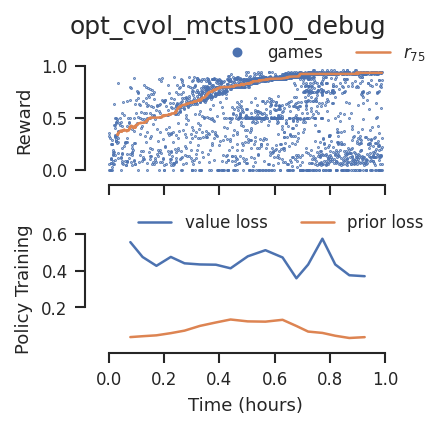

                                                  digest                 hash  \
37688  4de8009af1dd428527a7be86463a6065f4ce887315b3e4...  8802997818691025470   
80754  d5fdfe5f0cc71e07996872417bb2d639b80780ef9c8ae9...  8802997818691025470   
94823  c1220764ef90087cba352cb25e3f8eb74a590d1ba71971...  7214899612293632996   
80890  cb3138350dda964f0cc9b252cecf6b44c05b35dbd9359d...  7000003398653280363   
83988  0433e150332f0c0d540d7b5c929ac2e446c304361cb257...  9118850087464527793   

                       run_id                       time   reward  \
37688  opt_cvol_mcts100_debug 2021-07-09 14:02:47.286220  0.95487   
80754  opt_cvol_mcts100_debug 2021-07-09 14:24:29.741205  0.95487   
94823  opt_cvol_mcts100_debug 2021-07-09 14:33:35.249387  0.95487   
80890  opt_cvol_mcts100_debug 2021-07-09 14:24:35.524485  0.95487   
83988  opt_cvol_mcts100_debug 2021-07-09 14:27:24.626318  0.95487   

                                                    data  
37688  {'terminal': True, 'conducting_i

In [11]:
df_rew = main_results(run_id, session)

In [12]:
df_rew.head()

,digest,hash,run_id,time,reward,data
37688,4de8009af1dd428527a7be86463a6065f4ce887315b3e4...,8802997818691025470,opt_cvol_mcts100_debug,2021-07-09 14:02:47.286220,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
80754,d5fdfe5f0cc71e07996872417bb2d639b80780ef9c8ae9...,8802997818691025470,opt_cvol_mcts100_debug,2021-07-09 14:24:29.741205,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
94823,c1220764ef90087cba352cb25e3f8eb74a590d1ba71971...,7214899612293632996,opt_cvol_mcts100_debug,2021-07-09 14:33:35.249387,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
80890,cb3138350dda964f0cc9b252cecf6b44c05b35dbd9359d...,7000003398653280363,opt_cvol_mcts100_debug,2021-07-09 14:24:35.524485,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
83988,0433e150332f0c0d540d7b5c929ac2e446c304361cb257...,9118850087464527793,opt_cvol_mcts100_debug,2021-07-09 14:27:24.626318,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."


In [13]:
len(df_rew)

104517

In [14]:
df_rew['hash'].nunique()

73054

In [18]:
df_rew[df_rew['reward'] > .9]['hash'].nunique()

87

                                     id              run_id  \
0  53deb0ff-b84d-4c5c-bb67-48f958867aa2  more_complex_debug   
1  4306296a-7ac9-45e6-ad01-9dbe2a3cadcf  more_complex_debug   
2  06ecb0af-18cc-433b-bf05-f01843b33a3c  more_complex_debug   
3  3818753b-5e0e-4d28-829d-1de4f0d42197  more_complex_debug   
4  94a1afaf-5dcc-4772-b72d-0bbc754c2ab6  more_complex_debug   

                        time  raw_reward  scaled_reward  \
0 2021-07-16 16:31:42.329489    0.048714            1.0   
1 2021-07-16 16:31:42.382340    0.155115            1.0   
2 2021-07-16 16:31:56.347513    0.688247            1.0   
3 2021-07-16 16:31:56.513132    0.304761            1.0   
4 2021-07-16 16:32:00.701230    0.232972            0.0   

                                   search_statistics  \
0  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
1  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
2  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
3  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc

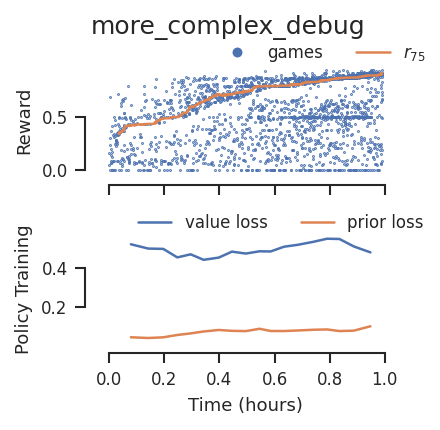

                                                   digest  \
86079   cebf9d2702e974f0783565151984e78d14ccc3986fd8b8...   
106332  d0a10c15429d7859a27612a79548d9b4801f474519f718...   
76191   9d2a034e19969c577e5a60f8309539bce9d75dcc26d0a1...   
102202  bbacdfabba4a882ff44a861535b918928a513ce6158a63...   
93062   823ed19aa9a6df4392073ae4ba0ceb539814576a0300c5...   

                       hash              run_id                       time  \
86079   6365513629074300998  more_complex_debug 2021-07-16 17:18:44.224498   
106332  2404015317369171244  more_complex_debug 2021-07-16 17:29:07.814993   
76191   2404015317369171244  more_complex_debug 2021-07-16 17:14:05.294967   
102202  4835184247465134124  more_complex_debug 2021-07-16 17:26:59.341756   
93062   2404015317369171244  more_complex_debug 2021-07-16 17:22:20.415604   

          reward                                               data  
86079   0.943824  {'terminal': True, 'conducting_ion_vol': 3222....  
106332  0.943824  {'term

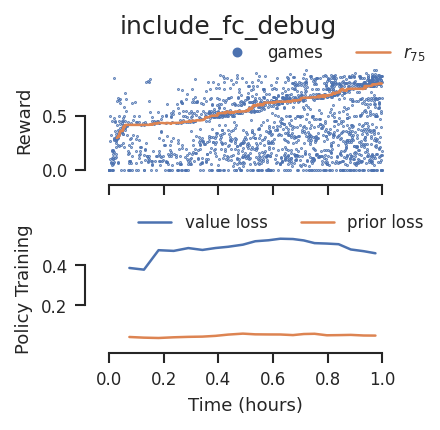

                                                  digest                 hash  \
83700  fa3a9c60f8969a293c50b8ec3d901996b0aef2acee5d4a...  1756656333573177920   
84132  6bef6b925309a9e6d8d0d3936a21173955cf01327db4be...   268487914446145353   
56503  fb0c9c620ccc078e06358a79230f78fd6e8e15a633e8c1...  2410950498115942858   
77455  70aea52ddaf0f0321edf485fd8e81bcf3d0a329c622975...  2410950498115942858   
87706  0833a49f870b94ccbe0276c28cc4e6ed547532781c09be...  1756656333573177920   

                 run_id                       time    reward  \
83700  include_fc_debug 2021-07-16 18:20:45.573136  0.920894   
84132  include_fc_debug 2021-07-16 18:21:04.145228  0.920894   
56503  include_fc_debug 2021-07-16 18:05:19.434322  0.920894   
77455  include_fc_debug 2021-07-16 18:17:21.978373  0.920894   
87706  include_fc_debug 2021-07-16 18:23:26.975180  0.920894   

                                                    data  
83700  {'terminal': True, 'conducting_ion_vol': 158.6...  
84132  {'t

In [11]:
# initial results
for run_id in ["more_complex_debug", "include_fc_debug"]:
    df_rew = main_results(run_id, session)

                                     id              run_id  \
0  2e7ad6b0-80f6-4d50-958f-e53d87238ba3  include_fc_debug_3   
1  e0465d2d-4e30-4826-b6de-47d6f01472ea  include_fc_debug_3   
2  06e2c107-22b2-4bac-8a58-90ca50bd7fab  include_fc_debug_3   
3  7f00891c-e3e8-44c1-9f2c-7b0917fb97ed  include_fc_debug_3   
4  23f11438-617a-483d-ac07-450c0ef22b5c  include_fc_debug_3   

                        time  raw_reward  scaled_reward  \
0 2021-07-17 11:04:44.890123    0.000000            1.0   
1 2021-07-17 11:04:46.924200    0.000000            0.0   
2 2021-07-17 11:04:48.220963    0.000000            0.0   
3 2021-07-17 11:04:53.024796    0.392534            0.0   
4 2021-07-17 11:04:54.319946    0.000000            0.0   

                                   search_statistics  \
0  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
1  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
2  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
3  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc

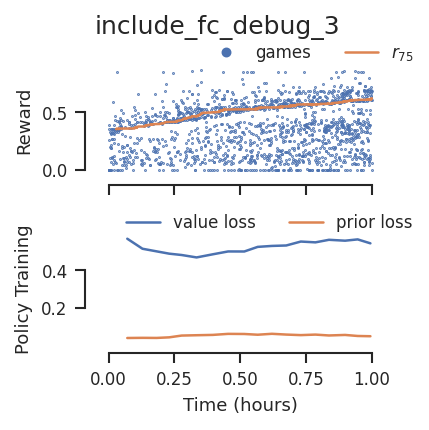

                                                  digest                 hash  \
51927  aca68bd617157f146de2f0396553596023ffc189bac75e...  5226064925282629680   
3534   14dee084d38ec1a05ceee325f28e11dc3bc7b01d5852f9...  8667121723854735920   
54401  ae4fc7d95c5024653710a2e7b093a2e48f2f31c93c9c57...  1527988293595884890   
67246  e398532260a6f074a3166aef236cf7060c6f556d60a0fc...  3047976988927894889   
24476  358c3d4ae26c5d9bf38ad42f3a97593f48407db831a56c...   586819620574928142   

                   run_id                       time    reward  \
51927  include_fc_debug_3 2021-07-17 11:36:13.329435  0.899258   
3534   include_fc_debug_3 2021-07-17 11:06:34.765746  0.899258   
54401  include_fc_debug_3 2021-07-17 11:37:24.953272  0.899258   
67246  include_fc_debug_3 2021-07-17 11:44:54.788301  0.899258   
24476  include_fc_debug_3 2021-07-17 11:19:13.895288  0.899258   

                                                    data  
51927  {'terminal': True, 'conducting_ion_vol': 608.8... 

,digest,hash,run_id,time,reward,data
51927,aca68bd617157f146de2f0396553596023ffc189bac75e...,5226064925282629680,include_fc_debug_3,2021-07-17 11:36:13.329435,0.899258,"{'terminal': True, 'conducting_ion_vol': 608.8..."
3534,14dee084d38ec1a05ceee325f28e11dc3bc7b01d5852f9...,8667121723854735920,include_fc_debug_3,2021-07-17 11:06:34.765746,0.899258,"{'terminal': True, 'conducting_ion_vol': 608.8..."
54401,ae4fc7d95c5024653710a2e7b093a2e48f2f31c93c9c57...,1527988293595884890,include_fc_debug_3,2021-07-17 11:37:24.953272,0.899258,"{'terminal': True, 'conducting_ion_vol': 608.8..."


In [43]:
run_id = "include_fc_debug_3"
df_rew = main_results(run_id, session)
df_rew.head(3)

In [45]:
top_rew = df_rew[df_rew['reward'] > 0.85]
print(len(top_rew))

121


In [36]:
import pickle
import zlib

In [46]:
best_states = []
for i, (digest, hash_str, run_id, time, rew, data) in top_rew.iterrows():
#     if digest in df_state['digest']:
    states = get_state_for_rew(digest, df_state)
    for state_str in states['state']:
#         state_str = get_state_for_rew(digest, df_state)['state'].values[0]
# #     if hash_str in df_state['hash']:
# #         state_str = df_state[df_state['hash'] == hash_str]['state'].values[0]
        crystal = pickle.loads(zlib.decompress(state_str))
        best_states.append(crystal)
len(best_states)

0

In [47]:
best_decorations = set([str(c) + '|1' if '|1' not in str(c) else str(c) for c in best_states])
len(best_decorations)

0

In [30]:
from examples.crystal_volume import optimize_crystal_volume as ocv
from rlmolecule.crystal.crystal_state import CrystalState
from tqdm.notebook import tqdm

INFO:examples.crystal_volume.optimize_crystal_volume:reading ../../rlmolecule/crystal/inputs/icsd_prototypes.json.gz
INFO:examples.crystal_volume.optimize_crystal_volume:	4170 structures read


In [31]:
def write_decorated_structure(decorated_str, out_dir):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = ocv.structures[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}

    # Compute the volume of the conducting ions.
    conducting_ion_vol, total_vol = ocv.compute_structure_vol(decorated_structure)
    frac_conducting_ion_vol = conducting_ion_vol / total_vol if total_vol != 0 else 0
#     print(conducting_ion_vol, total_vol, frac_conducting_ion_vol)
    out_file = f"{out_dir}/POSCAR_{decorated_str.replace('|','-')}"
    print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return [conducting_ion_vol, total_vol, frac_conducting_ion_vol]

In [39]:
# now write each of these to a file
out_dir = f"outputs/{run_id}-0_85"
os.makedirs(out_dir, exist_ok=True)
volume_stats = {}
for decorated_str in tqdm(best_decorations):
    vol_stats = write_decorated_structure(decorated_str, out_dir)
    volume_stats[decorated_str] = [decorated_str.split('|')[-2]] + vol_stats

  0%|          | 0/65 [00:00<?, ?it/s]

Na2S1|_1_2|orthorhombic|POSCAR_sg70_icsd_248069|1 Na2S1 _1_2|orthorhombic|POSCAR_sg70_icsd_248069
writing outputs/more_complex_debug-0_85/POSCAR_Na2S1-_1_2-orthorhombic-POSCAR_sg70_icsd_248069-1
Na2O1|_1_2|cubic|POSCAR_sg227_icsd_170476|1 Na2O1 _1_2|cubic|POSCAR_sg227_icsd_170476
writing outputs/more_complex_debug-0_85/POSCAR_Na2O1-_1_2-cubic-POSCAR_sg227_icsd_170476-1
K2S1|_1_2|cubic|POSCAR_sg230_icsd_170477|1 K2S1 _1_2|cubic|POSCAR_sg230_icsd_170477
writing outputs/more_complex_debug-0_85/POSCAR_K2S1-_1_2-cubic-POSCAR_sg230_icsd_170477-1
Li2S1|_1_2|cubic|POSCAR_sg227_icsd_170476|1 Li2S1 _1_2|cubic|POSCAR_sg227_icsd_170476
writing outputs/more_complex_debug-0_85/POSCAR_Li2S1-_1_2-cubic-POSCAR_sg227_icsd_170476-1
K3P1|_1_3|monoclinic|POSCAR_sg14_icsd_413919|1 K3P1 _1_3|monoclinic|POSCAR_sg14_icsd_413919
writing outputs/more_complex_debug-0_85/POSCAR_K3P1-_1_3-monoclinic-POSCAR_sg14_icsd_413919-1
Na2S1|_1_2|cubic|POSCAR_sg217_icsd_173559|1 Na2S1 _1_2|cubic|POSCAR_sg217_icsd_173559
writi

KeyboardInterrupt: 

In [ ]:
df_vol_stats = pd.DataFrame(volume_stats).T
df_vol_stats.columns = ['icsd_prototype', 'conducting_ion_vol', 'total_vol', 'fraction']
df_vol_stats.head()

In [ ]:
out_file = f"{out_dir}/volume_stats.tsv"
df_vol_stats.to_csv(out_file, sep='\t')